In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 20 09:42:10 2020

@author: rhoover
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from t_svd import *
from networkx.generators.community import LFR_benchmark_graph

##  Tensor packages for Tucker, etc.  ###
from sktensor.tucker import hooi
from sktensor import dtensor

### Standard Linear Algebra Package  ###
from scipy import linalg

In [2]:
plt.close()

N = 20 # Time steps
n = 40 # Nodes
p = 0.4

adj = np.zeros([n,n,2*N+2])

In [3]:
# Create random graph and store to the last lateral slice of adj
G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,0] = G_adj # Stoer the first adjacency matrix in the first frontal slice of adj

In [4]:
# Create another random graph and store to the last lateral slice of adj
#G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
#G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,(2*N+2) - 1] = G_adj # Store the last adjacency matrix in the last frontal slice of adj

In [5]:
#  Generate graph community over 20 graphs.
for i in range(1,N+1):
    q = p-p*i/(N+1)
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/2),int(n/2)],P))
    adj[0:n,0:n,i] = Gsbm
    #print(i)

In [6]:
###  Generate back end (from communities to single community) - and plot in the loop
eps = 0.0
print('The j vector')
for j in range(1,N+2):
    q = p*(j-1)/(N+2) + eps#remove the eps for complete dissconnectivity #
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/2),int(n/2)],P))
    adj[0:n,0:n,i+j] = Gsbm
    #print(i+j)

The j vector


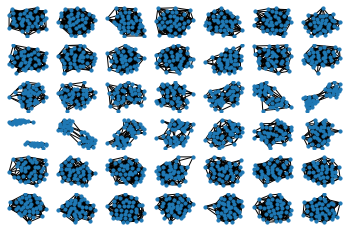

In [7]:
####  Visualization of the graphs
plt.figure(1)
for i in range(2*N+2):
    plt.subplot(6,7,i+1)
    nx.draw(nx.from_numpy_matrix(adj[0:n,0:n,i]),node_size = 10)

In [8]:
#### Generate ind matrix
ind = np.zeros(adj.shape)

for t in range (2*N+2):
    for node in range(n):
        ind[node, node, t] = sum(adj[node, :, t])
#print(ind[1:5, 1:5, 18:22])
        

/home/riley/git/multi_linear_research/riley/env/lib/python3.8/site-packages/sktensor/tucker.py:113: RuntimeWarning: invalid value encountered in sqrt
  normresidual = np.sqrt(normX ** 2 - norm(core) ** 2)


[1.34004413e+01 1.30580021e+01 1.22769109e+01 1.18699189e+01
 1.16490264e+01 1.08285484e+01 1.07403020e+01 1.05735301e+01
 1.03646785e+01 1.00814829e+01 9.68676349e+00 9.54514645e+00
 9.36210143e+00 9.35560879e+00 8.84864167e+00 8.79509022e+00
 8.45008533e+00 8.26596745e+00 7.63304195e+00 7.57783071e+00
 7.38650891e+00 7.23461618e+00 6.87214800e+00 6.55608225e+00
 6.40750942e+00 6.34879623e+00 5.92571023e+00 5.54314260e+00
 5.41566042e+00 4.96336243e+00 4.76295296e+00 4.58593367e+00
 4.30431521e+00 3.93840168e+00 3.83761788e+00 2.81116440e+00
 2.48848307e+00 2.25447558e+00 4.65598466e-16 1.91252314e-16]


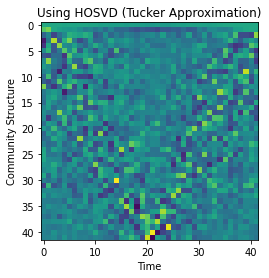

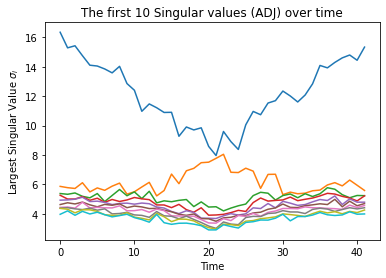

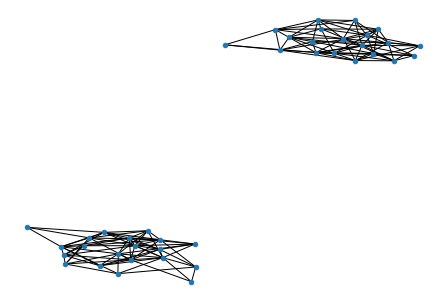

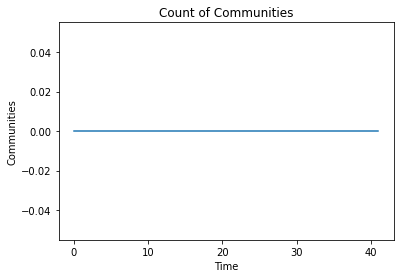

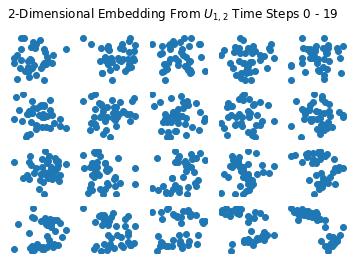

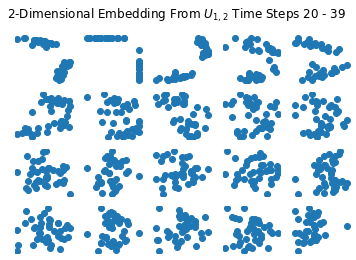

In [9]:
####  Decompose using the Tucker decomposition  ####
T = dtensor(adj)
Y = hooi(T, [n, n, 2*N+2], init='nvecs')

U1 = Y[1][0]
U2 = Y[1][1]
U3 = Y[1][2]

plt.figure(2)

plt.imshow(U3.T)
plt.xlabel('Time')
plt.ylabel('Community Structure')
plt.title('Using HOSVD (Tucker Approximation)')

s_vec = np.zeros([10, 2*N+2])
U_data = np.zeros([n,n,2*N+2])
V_data = np.zeros([n,n,2*N+2])
for i in range(2*N+2):
    U, s, Vh = np.linalg.svd(adj[0:n,0:n,i],full_matrices = True, compute_uv = True)
    for j in range(0, 10):
        s_vec[j,i] = s[j]
    U_data[0:n,0:n,i] = U
    V_data[0:n,0:n,i] = Vh

plt.figure(3)
for j in range(0, 10):
    plt.plot(s_vec[j, :])
plt.xlabel('Time')
plt.ylabel('Largest Singular Value $\sigma_i$')
plt.title('The first 10 Singular values (ADJ) over time')

#####################
debug = 21
#Generate Lapacians
lap = np.subtract(ind, adj)
#print(lap[:,:,21])
#print(lap.shape)
plt.figure(7)
nx.draw(nx.from_numpy_matrix(adj[:,:,debug]),node_size = 20)

communities = np.zeros(2*N+2)

for i in range(2*N+2):
    s = np.linalg.svd(lap[:,:,i], compute_uv = False)
    communities[i] = len(s) - np.count_nonzero(s)
    if i == debug:
        print(s)

plt.figure(4)
plt.plot(communities)
plt.xlabel('Time')
plt.ylabel('Communities')
plt.title('Count of Communities')

#####################

plt.figure(5)
for i in range(N):
    plt.subplot(4,5,i+1)
    plt.scatter(U_data[0:n,0:1,i],U_data[0:n,1:2,i])

    plt.axis('off')
plt.suptitle('2-Dimensional Embedding From $U_{1,2}$ Time Steps 0 - 19')

plt.figure(6)
plt_cnt = 1
for i in range(N,2*N):
    plt.subplot(4,5,plt_cnt)
    plt.scatter(U_data[0:n,0:1,i],U_data[0:n,1:2,i])
    plt_cnt +=1
    plt.axis('off')
plt.suptitle('2-Dimensional Embedding From $U_{1,2}$ Time Steps 20 - 39')
plt.show()

In [13]:
print(t_svd(adj))

(array([[[-3.18326747e-02,  1.84650350e-02, -1.95856777e-02, ...,
          7.58956860e-03, -7.98400409e-03, -2.87048791e-02],
        [-1.00131461e-02,  3.90770442e-03,  1.55767854e-02, ...,
         -1.18517750e-02,  6.81651066e-03,  1.98734680e-02],
        [ 2.38898325e-02, -3.44011633e-02,  1.77085237e-02, ...,
         -9.23041960e-03, -8.03755277e-03,  3.12270139e-02],
        ...,
        [ 9.50205076e-03,  1.00222646e-03, -1.02704352e-02, ...,
          1.43239227e-02,  1.77287114e-03,  8.72445525e-03],
        [-1.69425016e-02, -4.61381707e-03, -2.32884384e-02, ...,
          1.36898317e-02, -3.36603039e-02,  3.80419562e-02],
        [-2.36194798e-02,  2.33710185e-02,  3.60213327e-02, ...,
         -7.70492615e-03, -3.66422663e-02, -3.69176332e-03]],

       [[ 1.52987210e-02, -5.77526191e-02,  4.84300263e-02, ...,
          4.70905807e-02,  5.21821315e-02,  5.78724948e-02],
        [-1.27338486e-02, -4.16732727e-02, -6.01206548e-03, ...,
          1.77875023e-02,  3.29229302